In [44]:
library("httr")
library("jsonlite")

library(ggplot2)

library(tseries)
library(forecast)
library(rugarch)

In [47]:
url <- "https://api.iextrading.com/1.0"
ticker <- "IETC"
endpoint <- paste("/stock/", ticker, "/chart/1y", sep="")
url <- paste(url, endpoint, sep="")

length <- 200
query <- list(chartLast=length) 

request <- GET(url, query=query)
response <- content(request, as="text")
df <- fromJSON(response, flatten = TRUE) 
price <- df[c("date", "close")]
write.csv(price, "/home/carson/Desktop/price.csv", row.names=FALSE)

s <- ts(log(price$close))
ds <- diff(s)

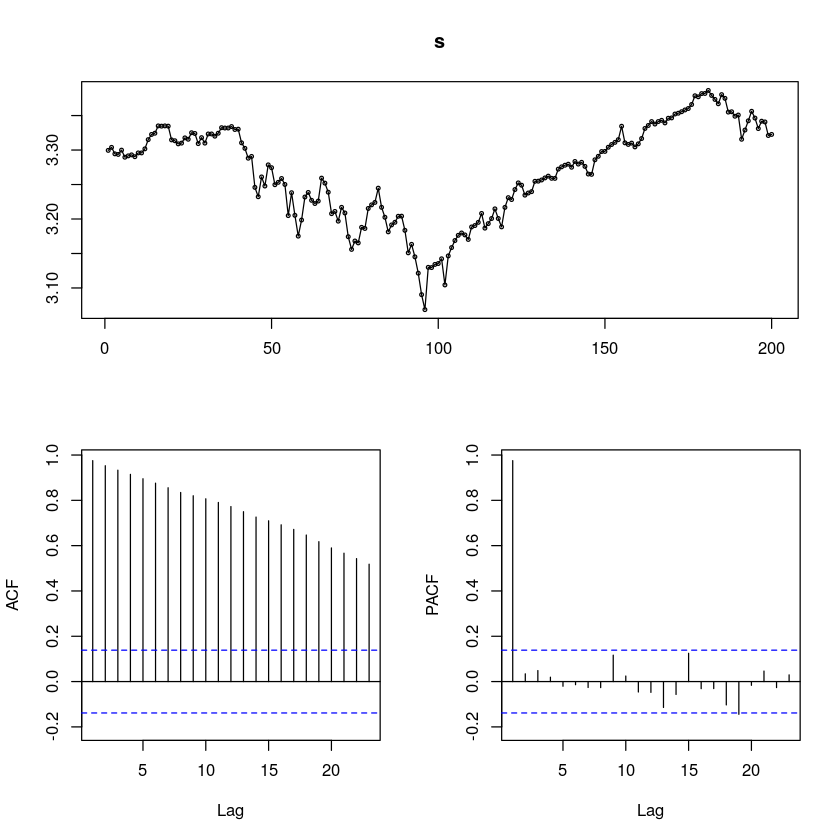

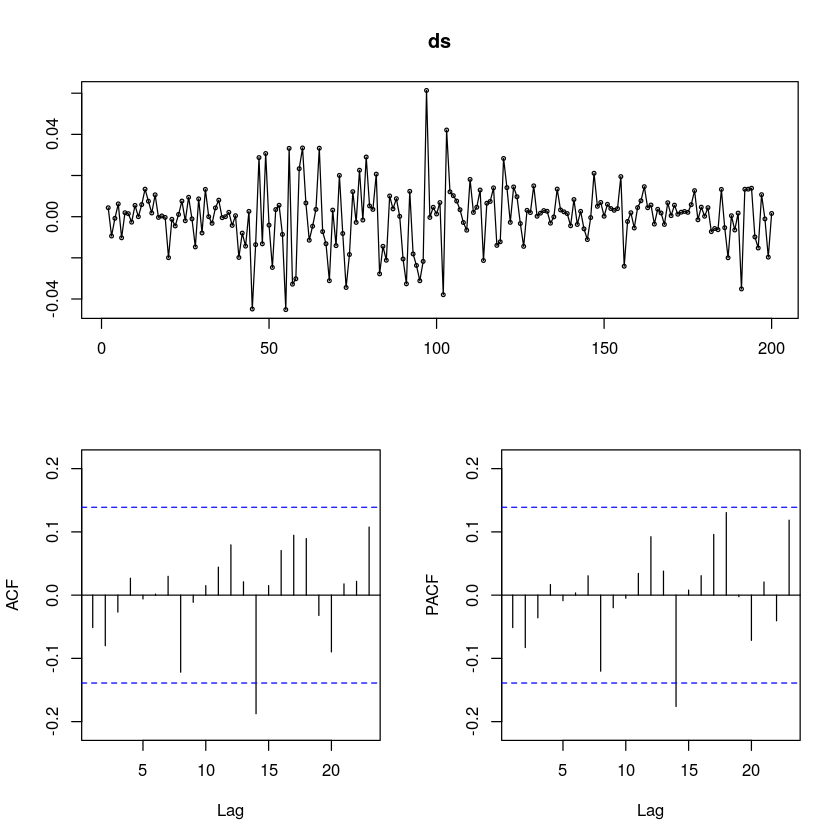

In [48]:
tsdisplay(s)
tsdisplay(ds)

In [49]:
fit <- auto.arima(s, seasonal=FALSE)
fit

Series: s 
ARIMA(0,1,0) 

sigma^2 estimated as 0.0002187:  log likelihood=556.24
AIC=-1110.47   AICc=-1110.45   BIC=-1107.18

In [50]:
fit <- auto.arima(ds, seasonal=FALSE)
fit

Series: ds 
ARIMA(0,0,0) with zero mean 

sigma^2 estimated as 0.0002186:  log likelihood=556.24
AIC=-1110.47   AICc=-1110.45   BIC=-1107.18

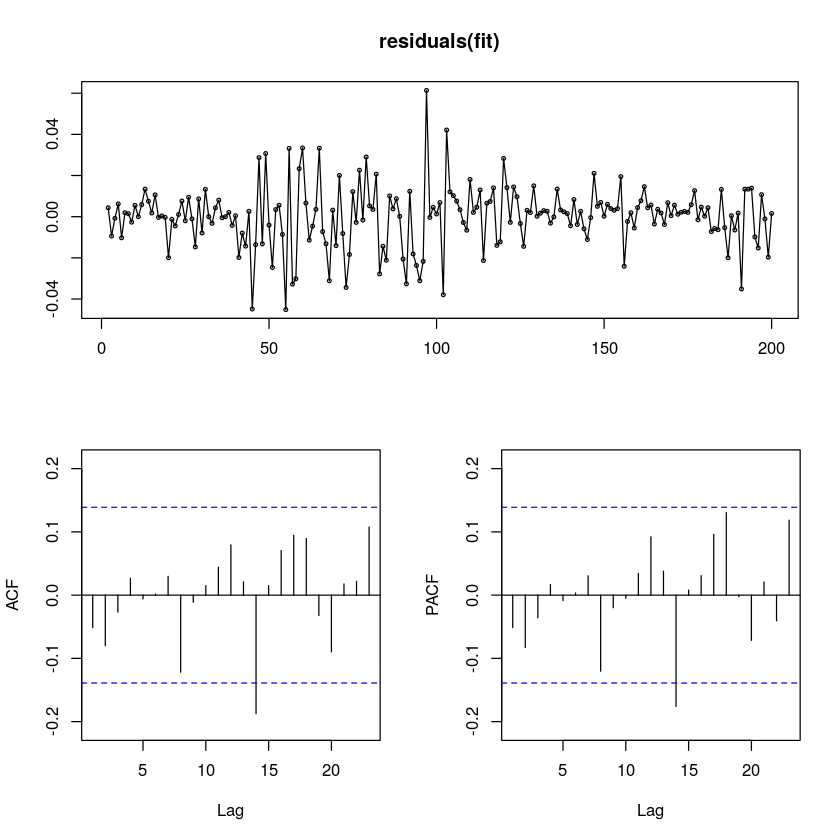

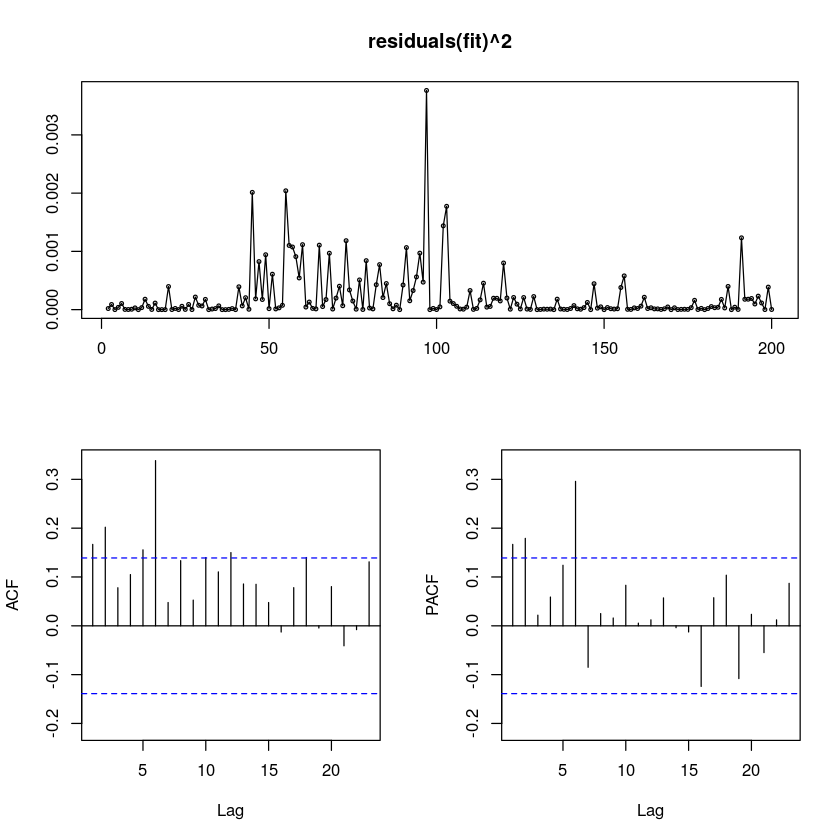

In [51]:
tsdisplay(residuals(fit, standardize=TRUE))
tsdisplay(residuals(fit, standardize=TRUE)^2)

In [52]:
garchSpec <- ugarchspec(variance.model=list(model="sGARCH",
                               garchOrder=c(2,2)),
           mean.model=list(armaOrder=c(0,0)), 
           distribution.model="std")

garchFit <- ugarchfit(spec=garchSpec, data=ds)

In [53]:
garchFit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(2,2)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001322    0.000685 1.930482 0.053547
omega   0.000010    0.000009 1.145520 0.251994
alpha1  0.090194    0.069084 1.305578 0.191696
alpha2  0.280453    0.100644 2.786589 0.005327
beta1   0.000019    0.104590 0.000182 0.999855
beta2   0.628333    0.108617 5.784854 0.000000
shape   4.604648    1.887538 2.439500 0.014708

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001322    0.000823 1.606545 0.108154
omega   0.000010    0.000010 1.064136 0.287267
alpha1  0.090194    0.062479 1.443593 0.148853
alpha2  0.280453    0.093540 2.998229 0.002716
beta1   0.000019    0.061746 0.000308 0.999754
beta2   0

In [65]:
res <- residuals(garchFit, standardize=TRUE)

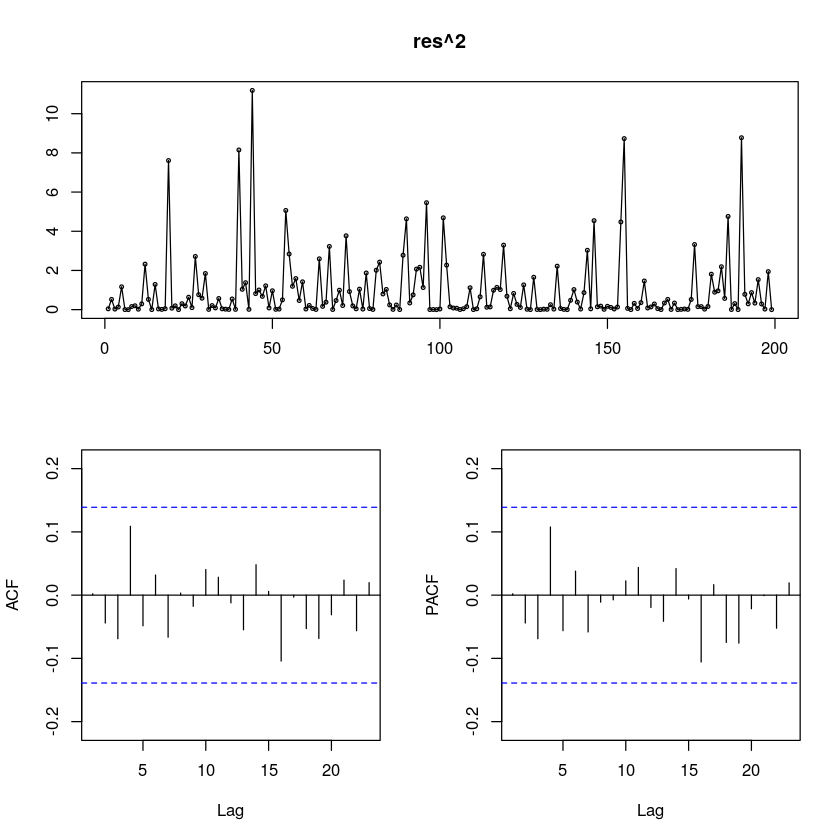

In [67]:
tsdisplay(res^2)

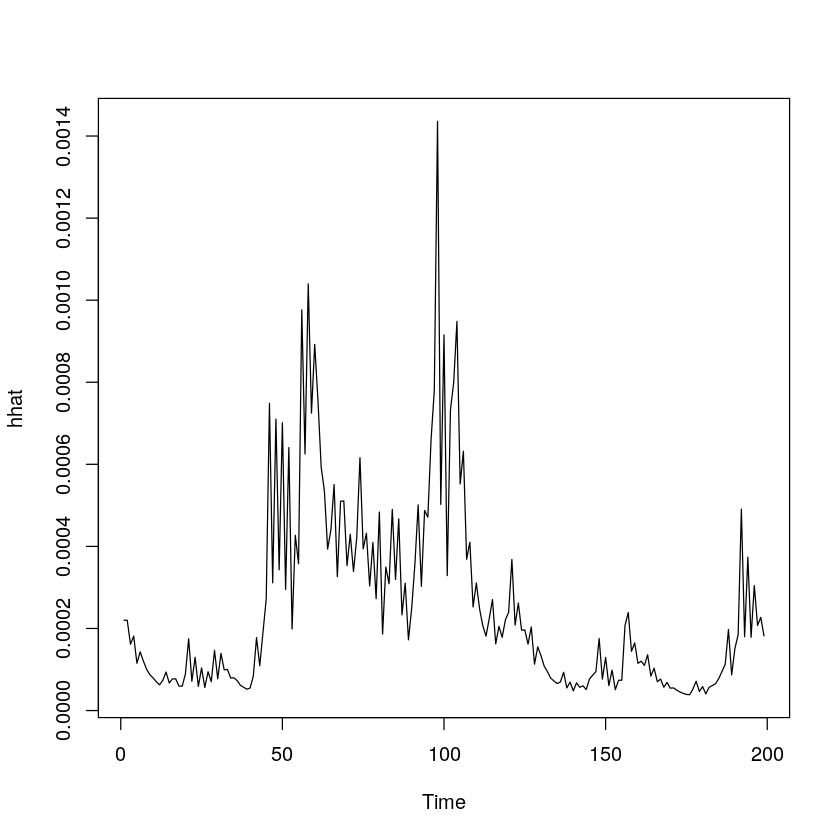

In [19]:
hhat <- ts(garchFit@fit$sigma^2)
plot.ts(hhat)

In [130]:
ndf <- read.csv("http://download.macrotrends.net/assets/php/stock_data_export.php?t=AAPL", skip=14)
ndf$date <- as.Date(ndf$date)
head(ndf)

date,open,high,low,close,volume
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1980-12-12,0.5134,0.5155,0.5134,0.5134,117258400
1980-12-15,0.4889,0.4889,0.4866,0.4866,43971200
1980-12-16,0.4530,0.4530,0.4509,0.4509,26432000
1980-12-17,0.4620,0.4643,0.4620,0.4620,21610400
1980-12-18,0.4755,0.4777,0.4755,0.4755,18362400
1980-12-19,0.5045,0.5068,0.5045,0.5045,12157600


In [192]:
price <- ndf[c("date", "close")]
price <- subset(price, date > "1995-01-01")
head(price)

,date,close
,<date>,<dbl>
3553,1995-01-03,1.3707
3554,1995-01-04,1.4064
3555,1995-01-05,1.3886
3556,1995-01-06,1.5000
3557,1995-01-09,1.4714
3558,1995-01-10,1.5604


In [194]:
x <- log(price$close)

In [195]:
dx <- diff(x)
length(dx)

[1] 6142

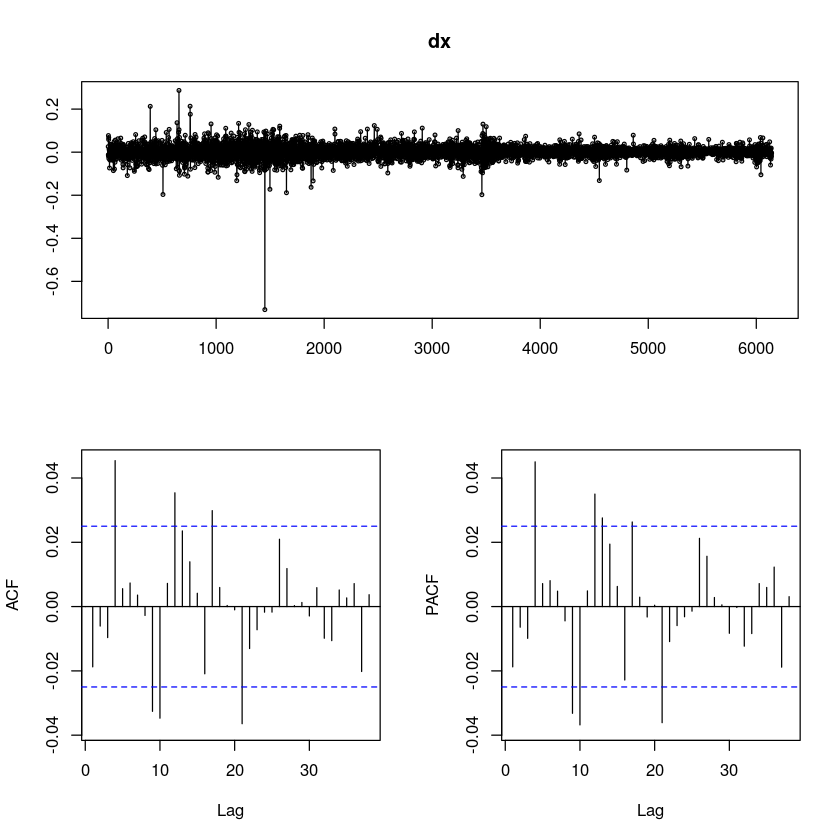

In [196]:
tsdisplay(dx)

Series: dx 
ARIMA(0,0,1) with non-zero mean 

Coefficients:
          ma1   mean
      -0.0190  8e-04
s.e.   0.0128  4e-04

sigma^2 estimated as 0.0008161:  log likelihood=13123.59
AIC=-26241.18   AICc=-26241.18   BIC=-26221.01

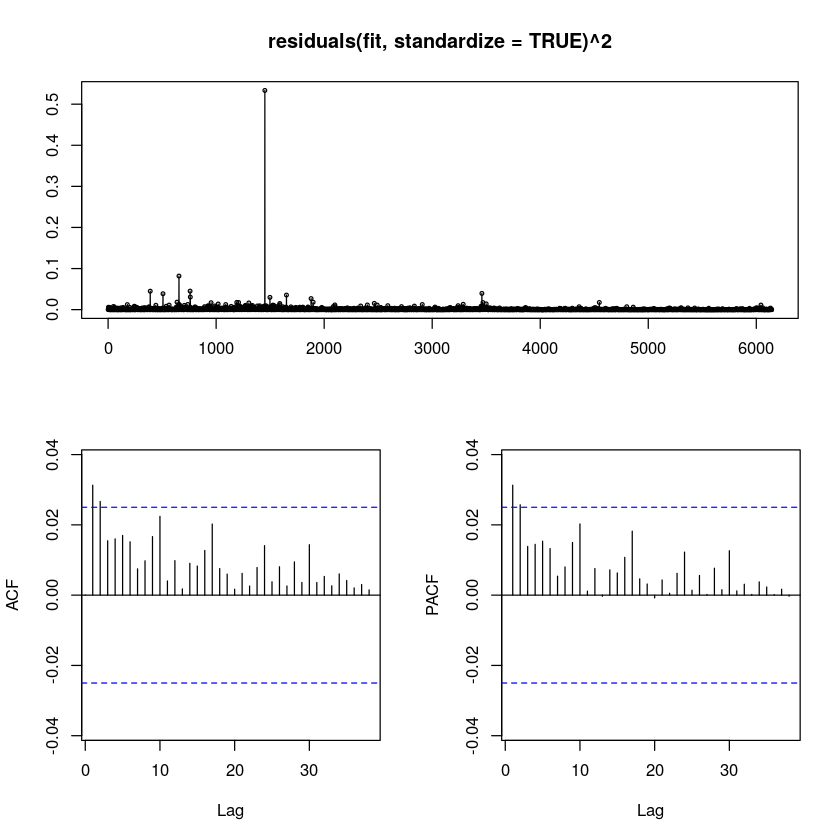

In [197]:
fit <- auto.arima(dx, seasonal=FALSE)
fit
tsdisplay(residuals(fit, standardize=TRUE)^2)

In [198]:
garchSpec <- ugarchspec(variance.model=list(model="sGARCH",
                               garchOrder=c(2,2)),
           mean.model=list(armaOrder=c(0,1)), 
           distribution.model="std")

garchFit <- ugarchfit(spec=garchSpec, data=dx)

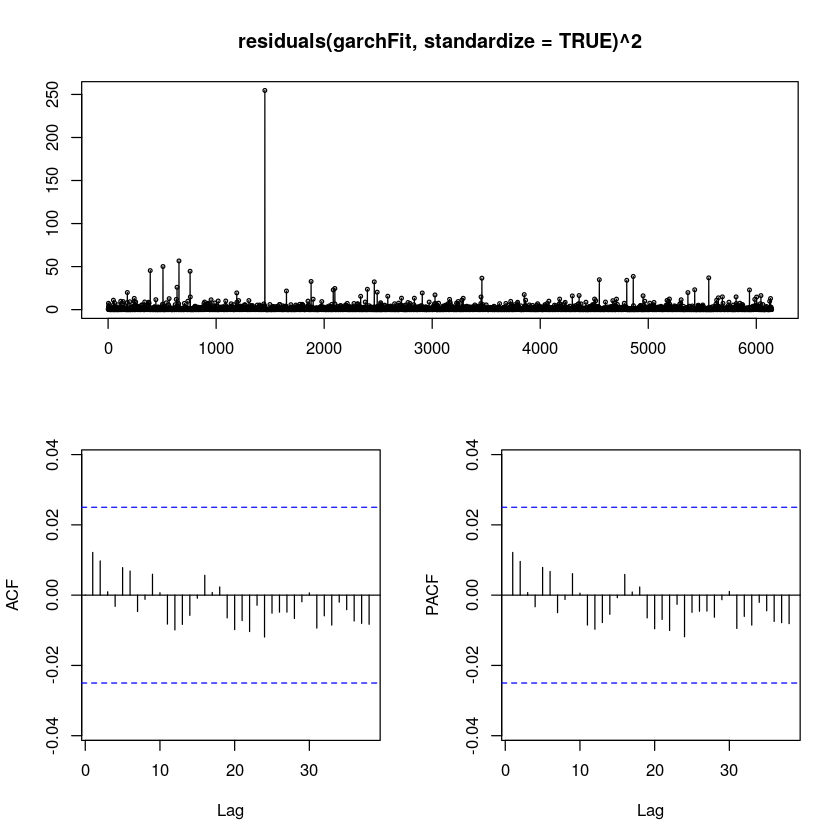

In [199]:
tsdisplay(residuals(garchFit, standardize=TRUE)^2)

In [205]:
model <- ugarchforecast(garchFit, n.ahead=10)

In [206]:
model


*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: sGARCH
Horizon: 10
Roll Steps: 0
Out of Sample: 0

0-roll forecast [T0=1986-10-25 19:00:00]:
       Series   Sigma
T+1  0.001157 0.01931
T+2  0.001121 0.01949
T+3  0.001121 0.01944
T+4  0.001121 0.01950
T+5  0.001121 0.01951
T+6  0.001121 0.01955
T+7  0.001121 0.01957
T+8  0.001121 0.01960
T+9  0.001121 0.01962
T+10 0.001121 0.01965



In [208]:
plot.ts(model@forecast, which="all")

ERROR: Error in xy.coords(x, NULL, log = log, setLab = FALSE): (list) object cannot be coerced to type 'double'
